# Real-Time Object Tracking using MOSSE Filters
## Tasks for Alex Marzban

- Set up development environment and dependencies (Python, OpenCV, NumPy).
- Implement video I/O and frame preprocessing pipeline (grayscale conversion, window cropping, cosine window).
- Code MOSSE filter initialization (training on first frame) and implement online filter update (Equations 10–12).
- Test preprocessing functions and filter update logic.
- Draft the Motivation, Approach and Implementation Details sections of the project report.


In [5]:
import cv2
import numpy as np

#if inline doesn't work, try:
#%matplotlib qt
#%matplotlib tk
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#Functions for selecting initial object
def select_roi_from_video(video_path, save_roi_file=None):
    #Selects roi and saves to a txt file if specified file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return None
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame of the video.")
        cap.release()
        return None
    roi = cv2.selectROI("Select ROI", frame, fromCenter=False, showCrosshair=True)
    cv2.destroyWindow("Select ROI")
    if save_roi_file:
        with open(save_roi_file, "w") as f:
            f.write(",".join(str(v) for v in roi))
        print(f"ROI saved to {save_roi_file}")
    cap.release()
    return roi

def load_roi(roi_file):
    with open(roi_file, "r") as f:
        roi_str = f.read().strip()
    return tuple(map(int, roi_str.split(",")))

video_path = 'Media/ballMoving.mov'  
roi = load_roi("roi.txt")
print("Selected ROI:", roi)

Selected ROI: (7, 373, 269, 280)


In [ ]:
#Functions to carry out MOSSE tracking

learning_rate = 0.125  #From the proposal

def create_cosine_window(width, height):
    #Using Hanning window for both dimensions and compute the outer product
    hann_1d_w = np.hanning(width)
    hann_1d_h = np.hanning(height)
    cosine_window = np.outer(hann_1d_h, hann_1d_w)
    return cosine_window

def preprocess_frame(frame, roi):
    """
    Preprocess the frame:
    - Convert to grayscale
    - Crop the region of interest (roi) given as (x, y, w, h)
    - Normalize and apply a cosine window
    """

    x, y, w, h = roi
    #Convert to grayscale if not already
    if len(frame.shape) == 3:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray = frame.copy()
    
    cropped = gray[y:y+h, x:x+w]
    
    #Normalize the cropped image to have zero mean and unit norm
    cropped = cropped.astype(np.float32)
    cropped -= np.mean(cropped)
    norm = np.linalg.norm(cropped.flatten())
    if norm != 0:
        cropped /= norm
    
    #Apply cosine (Hanning) window
    cosine_window = create_cosine_window(w, h)
    preprocessed = cropped * cosine_window
    
    return preprocessed

def compute_fft(image):
    return np.fft.fft2(image)

def compute_ifft(fft_image):
    return np.fft.ifft2(fft_image).real

def create_desired_response(width, height, sigma=2.0):
    #Create a 2D Gaussian centered in the middle of the patch
    x = np.arange(0, width) - width // 2
    y = np.arange(0, height) - height // 2
    xv, yv = np.meshgrid(x, y)
    gaussian = np.exp(-0.5 * (xv**2 + yv**2) / (sigma ** 2))
    
    #Normalize so that the maximum is 1
    gaussian /= gaussian.max()
    return gaussian

def mosse_filter_init(first_frame, roi, num_perturbations=8):
    """
    Initialize the MOSSE filter using the first frame and ROI.
    Generates a set of perturbed training samples and computes the initial filter.
    Returns the initial A and B (numerator and denominator for the filter).
    """
    #Extract the roi
    x, y, w, h = roi
    A = 0
    B = 0
    
    #Desired response in the spatial domain (Gaussian) and its FFT
    g = create_desired_response(w, h, sigma=2.0)
    G = compute_fft(g)
    
    #Generate several small perturbations (using small random translations)
    for _ in range(num_perturbations):
        dx = np.random.randint(-3, 4)
        dy = np.random.randint(-3, 4)
        perturbed_roi = (max(x+dx,0), max(y+dy,0), w, h)
        
        #Preprocess the image patch
        patch = preprocess_frame(first_frame, perturbed_roi)
        
        #Compute FFT for training sample
        F = compute_fft(patch)
        
        #Update A and B using element-wise multiplication and conjugation
        A += G * np.conj(F)
        B += F * np.conj(F)
    
    return A, B

def update_mosse_filter(A_prev, B_prev, new_frame, roi, learning_rate=0.125):
    """
    Update the MOSSE filter using a new frame.
    Returns updated values of A and B.
    """

    x, y, w, h = roi
    
    #Create desired response (usually constant)
    g = create_desired_response(w, h, sigma=2.0)
    G = compute_fft(g)
    
    #Preprocess the new frame patch
    patch = preprocess_frame(new_frame, roi)
    F = compute_fft(patch)
    
    #Update formulas (Equations 11 and 12)
    A_new = learning_rate * (G * np.conj(F)) + (1 - learning_rate) * A_prev
    B_new = learning_rate * (F * np.conj(F)) + (1 - learning_rate) * B_prev
    
    return A_new, B_new

def compute_filter(A, B):
    """create_cosine_window
    Computes the MOSSE filter H in the Fourier domain as H = A / B.
    """
    
    eps = 1e-5  #avoid division by zero
    H = A / (B + eps)
    return H

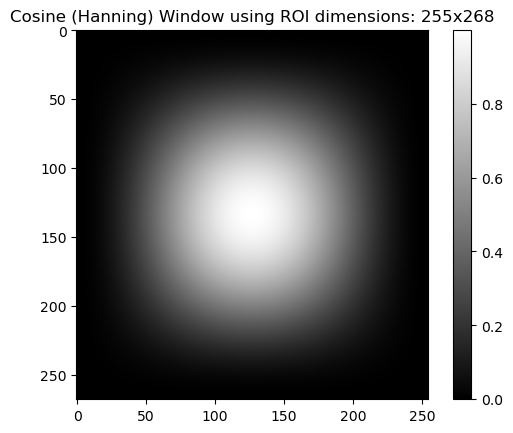

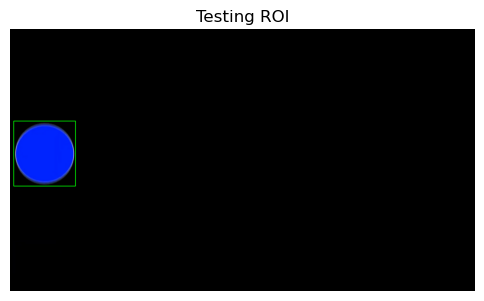

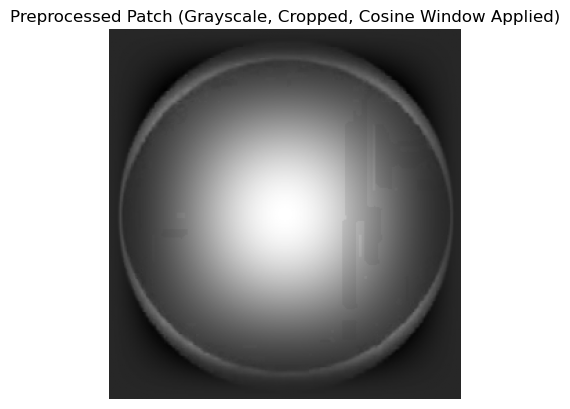

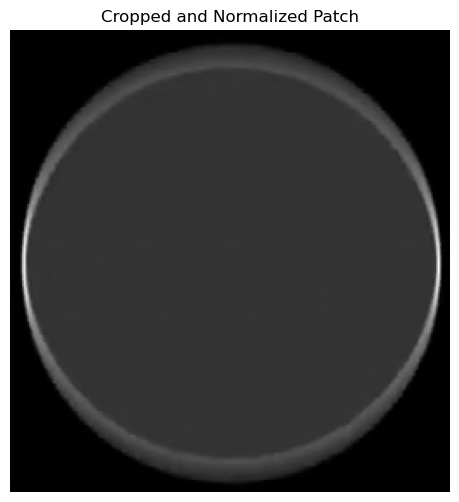

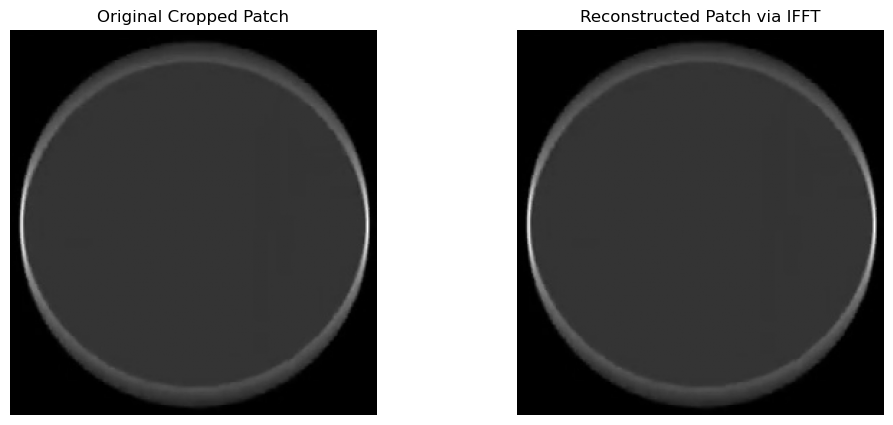

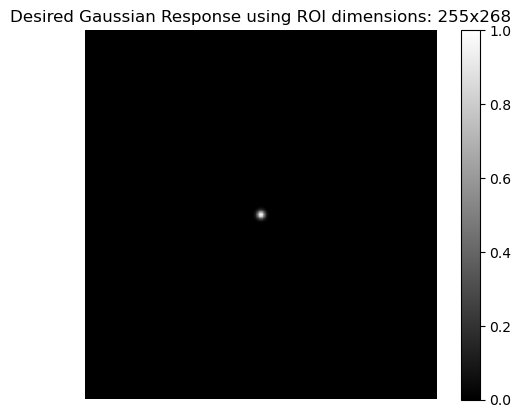

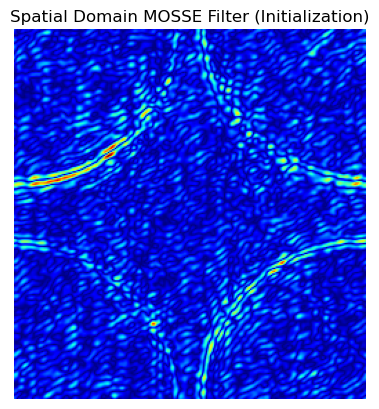

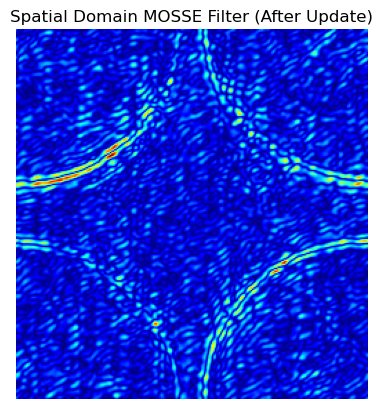

In [20]:
#Test functions
test_img = "Media/test_img.jpg"     
test_roi_file = "roiTest.txt" 

def display_image_with_roi(image, roi, window_title="Testing ROI"):
    x, y, w, h = roi
    image_copy = image.copy()
    cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
    image_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.title(window_title)
    plt.axis("off")
    plt.show()

def test_create_cosine_window():
    roi = load_roi(test_roi_file)
    _, _, w, h = roi
    #Create the cosine (Hanning) window using the ROI dimensions
    cosine_window = create_cosine_window(w, h)
    plt.imshow(cosine_window, cmap='gray')
    plt.title("Cosine (Hanning) Window using ROI dimensions: {}x{}".format(w, h))
    plt.colorbar()
    plt.show()

def test_preprocess_frame():
    #Load the test image
    image = cv2.imread(test_img)
    if image is None:
        raise ValueError("Test image not found.")
    
    roi = load_roi(test_roi_file)
    
    #Display the test image with ROI overlay first
    display_image_with_roi(image, roi, window_title="Testing ROI")
    
    preprocessed = preprocess_frame(image, roi)
    
    #Display the preprocessed patch
    plt.imshow(preprocessed, cmap='gray')
    plt.title("Preprocessed Patch (Grayscale, Cropped, Cosine Window Applied)")
    plt.axis("off")
    plt.show()

def test_fft_ifft():
    image = cv2.imread(test_img)
    if image is None:
        raise ValueError("Test image not found.")
    roi = load_roi(test_roi_file)
    
    #Extract the region of interest (crop the image)
    x, y, w, h = roi
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    #Crop the ROI and normalize it similarly to your preprocessing function
    patch = gray[y:y+h, x:x+w].astype(np.float32)
    patch -= np.mean(patch)
    norm = np.linalg.norm(patch.flatten())
    if norm != 0:
        patch /= norm
    plt.figure(figsize=(6,6))
    plt.imshow(patch, cmap='gray')
    plt.title("Cropped and Normalized Patch")
    plt.axis("off")
    plt.show()
    
    F = compute_fft(patch)
    patch_reconstructed = compute_ifft(F)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(patch, cmap='gray')
    plt.title("Original Cropped Patch")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(patch_reconstructed, cmap='gray')
    plt.title("Reconstructed Patch via IFFT")
    plt.axis("off")
    plt.show()

def test_create_desired_response():
    roi = load_roi(test_roi_file)
    _, _, width, height = roi
    gaussian = create_desired_response(width, height, sigma=2.0)
    plt.imshow(gaussian, cmap='gray')
    plt.title("Desired Gaussian Response using ROI dimensions: {}x{}".format(width, height))
    plt.colorbar()
    plt.axis("off")
    plt.show()

def test_mosse_initialization_and_update():
    frame = cv2.imread(test_img)
    if frame is None:
        raise ValueError("Test image not found.")
        
    roi = load_roi(test_roi_file)
    
    #Initialize the MOSSE filter
    A, B = mosse_filter_init(frame, roi)
    H = compute_filter(A, B)
    
    #Display the spatial domain filter magnitude for initialization
    H_spatial = compute_ifft(H)
    plt.imshow(np.abs(H_spatial), cmap='jet')
    plt.title("Spatial Domain MOSSE Filter (Initialization)")
    plt.axis("off")
    plt.show()
    
    rows, cols = frame.shape[:2]
    M = np.float32([[1, 0, 5], [0, 1, 5]])
    new_frame = cv2.warpAffine(frame, M, (cols, rows))
    
    #Update the filter with the new frame
    A_new, B_new = update_mosse_filter(A, B, new_frame, roi, learning_rate)
    H_new = compute_filter(A_new, B_new)
    
    #Display the updated filter in the spatial domain
    H_spatial_new = compute_ifft(H_new)
    plt.imshow(np.abs(H_spatial_new), cmap='jet')
    plt.title("Spatial Domain MOSSE Filter (After Update)")
    plt.axis("off")
    plt.show()

test_create_cosine_window()
test_preprocess_frame()
test_fft_ifft()
test_create_desired_response()
test_mosse_initialization_and_update()

In [ ]:
#Loop to process video frames using the MOSSE filter
def track_object_in_video(video_path, roi, max_frames=-1):
    """
    Process video and update the MOSSE filter for every frame.
    max_frames (int): Maximum number of frames to process (-1 for all frames)
    """

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    ret, first_frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return
    
    #Initialize the filter with the first frame
    A, B = mosse_filter_init(first_frame, roi)
    
    frame_count = 1
    while ret:
        ret, frame = cap.read()
        if not ret:
            break
        
        #Update the filter using the current frame (processing within the fixed ROI)
        A, B = update_mosse_filter(A, B, frame, roi, learning_rate)
        H = compute_filter(A, B)
        
        # Visualize the frame with the ROI overlay
        x, y, w, h = roi
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.imshow("Tracking", frame)
        
        key = cv2.waitKey(30) & 0xFF
        if key == 27:  #Press Esc key to exit early
            break
        
        frame_count += 1
        if max_frames > 0 and frame_count >= max_frames:
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [9]:
track_object_in_video(video_path, roi)